In [1]:
import networkx as nx
import numpy as np
import pandas as pd

import community as community_louvain

In [2]:
# for visualization
from IPython.display import SVG 
from sknetwork.visualization import svg_graph 
from sknetwork.data import Bunch 
from sknetwork.ranking import PageRank 
from scipy.sparse import csr_matrix

def draw_graph(G, show_names=False, node_size=1, font_size=10, edge_width=0.5):

    adjacency = nx.to_scipy_sparse_array(G, nodelist=None, dtype=None, weight='weight', format='csr')
    adjacency = csr_matrix(adjacency) # fix to weird sknetwork-csr issue; comment out to troubleshoot
    
    names = np.array(list(G.nodes))
    
    graph = Bunch()
    graph.adjacency = adjacency
    graph.names = np.array(names)
    
    pagerank = PageRank()
    scores = pagerank.fit_transform(adjacency)

    if show_names:
        
        image = svg_graph(graph.adjacency, font_size=font_size, node_size=node_size, names=graph.names, width=700, height=500, scores=scores, edge_width=edge_width)
    
    else:
        
        image = svg_graph(graph.adjacency, node_size=node_size, width=700, height=500, scores = scores, edge_width=edge_width)
    
    return SVG(image)

In [3]:
data = r'data/network_analysis_edgelist.csv'

df = pd.read_csv(data)
df.head()

source                               target
0  Network science                      Network science
1  Network science                Hub (network science)
2  Network science                       Network theory
3  Network science  National Science Foundation Network
4  Network science         Efficiency (network science)

In [4]:
G = nx.from_pandas_edgelist(df)

G.remove_edges_from(nx.selfloop_edges(G))

In [6]:
print(G)

Graph with 51268 nodes and 76211 edges


In [7]:
# this is network analysis network without labels; uncomment out to draw it; takes a minute

# draw_graph(G, node_size=1, show_names=False, edge_width=0.1)

# ORDER FROM CHAOS: Convert Graph to Learning Curriculum

The point of this notebook is to convert our complex "Network Science" network into a learning resource. I want to take a break from analyzing the network and use it to guide my own learning, to fill gaps in my knowlege.

I will use PageRank and Community Detection to identify knowledge "communities" that may be useful in learning. 

# PageRank - Identify Nodes of Interest

In [8]:
page_rank = nx.pagerank(G)

pr_df = pd.DataFrame().from_dict(page_rank, orient='index')
pr_df.columns = ['page_rank']
pr_df.sort_values('page_rank', ascending=False, inplace=True)
pr_df.head(10)

page_rank
Glossary of graph theory                   0.000341
List of statistics articles                0.000238
Internet                                   0.000206
Lists of mathematics topics                0.000188
Artificial intelligence                    0.000187
Computer network                           0.000185
Graph theory                               0.000185
Machine learning                           0.000180
List of unsolved problems in mathematics   0.000178
List of graph theory topics                0.000171

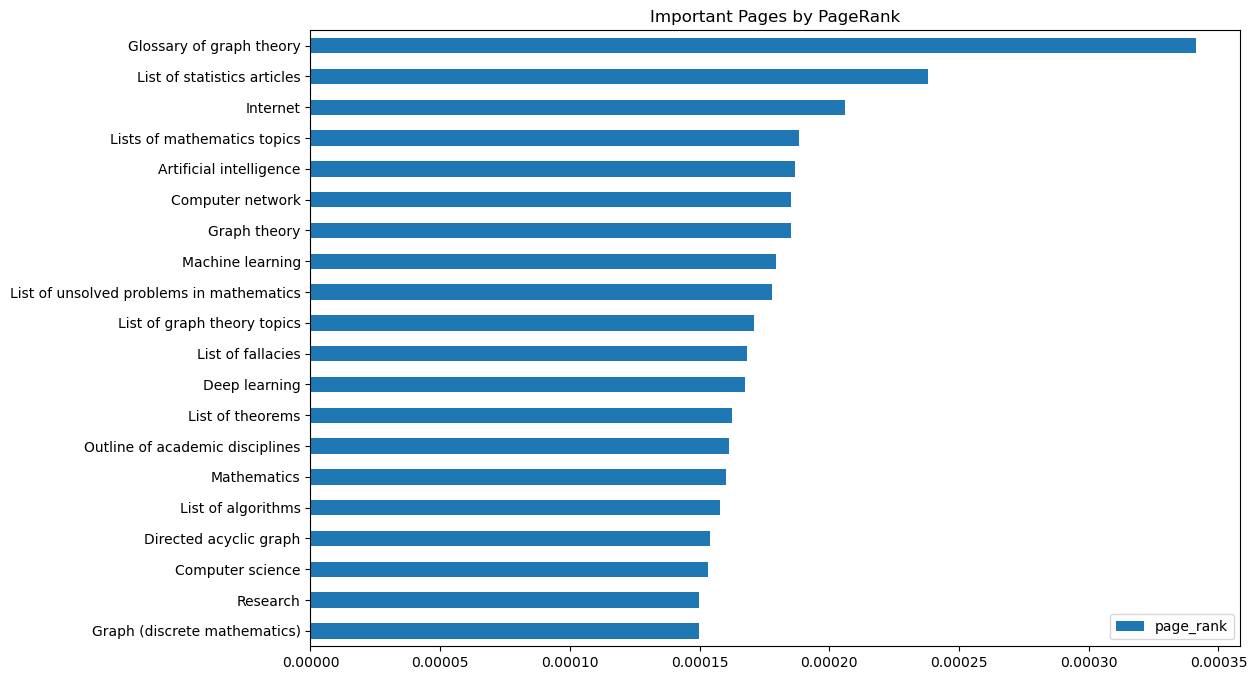

In [9]:
title = 'Important Pages by PageRank'

pr_df.head(20).plot.barh(figsize=(12,8), title=title).invert_yaxis()

# Community Detection

We have one large connected component, and this will be great for use in Community Detection. The smaller connected components are communities of their own in this network, split off from the main piece of this network.

In [10]:
def draw_partition(G, partition): 

    import matplotlib.cm as cm 
    import matplotlib.pyplot as plt 

    # draw the graph 
    plt.figure(3,figsize=(12,12)) 
    pos = nx.spring_layout(G) 

    # color the nodes according to their partition 
    cmap = cm.get_cmap('jet', max(partition.values()) + 1) 
    nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values())) 
    nx.draw_networkx_edges(G, pos, alpha=0.5, width=0.3) 

    return plt.show() 

In [11]:
# identify communities; set resolution to 0.01 for smaller groups and 1 for larger groups, etc
# play with the number to get communities to the size you want them, or leave it at the default

partition = community_louvain.best_partition(G, resolution=0.1, random_state=1337) 

In [12]:
community_df = pd.DataFrame().from_dict(partition, orient='index')
community_df.reset_index(inplace=True)
community_df.columns = ['node', 'community']

# remove junk; identify relevant communities
community_df = community_df[community_df['node'].str.contains('network|graph|science|inference')]

community_df['community'].value_counts()[0:20]

community
62      290
5        50
3        49
15       49
39       25
180      23
456      22
590      17
83       16
135      15
587      14
1090     13
803      13
188      12
840      12
730      11
911      10
600      10
435       9
2         9
Name: count, dtype: int64

In [13]:
comm_idx = community_df['community'].value_counts()[0:20].index.values
comm_idx

array([  62,    5,    3,   15,   39,  180,  456,  590,   83,  135,  587,
       1090,  803,  188,  840,  730,  911,  600,  435,    2], dtype=int64)

## Exploring Communities
Below, I am showing the largest community in the network. Looking at some of the node labels, I can see many instances of the word "graph". We are in the right place. 

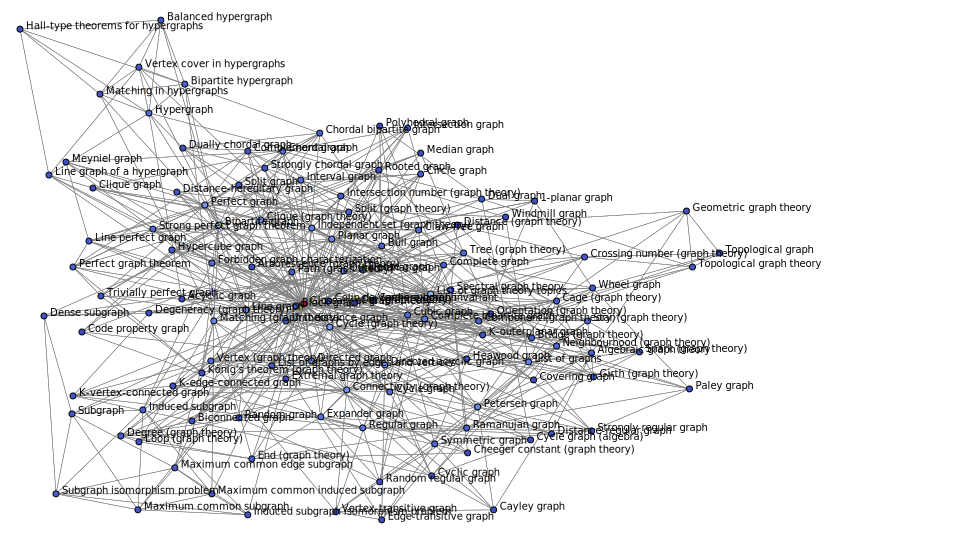

In [14]:
nodes = community_df[community_df['community']==comm_idx[0]]['node'].values

G_comm = G.subgraph(nodes)
G_net_main = G_comm.copy() # we will run community detection off of this at the end

draw_graph(nx.k_core(G_comm, 5), show_names=True, node_size=3)

In [15]:
netsci_nodes = [n for n in sorted(G_net_main.nodes)]
[print(n) for n in netsci_nodes]

1-planar graph
Acyclic graph
Algebraic graph theory
Ancestral graph
Apex graph
Arborescence (graph theory)
Area (graph drawing)
Babyface discography
Balanced hypergraph
Berlekamp–Van Lint–Seidel graph
Biconnected graph
Bidirected graph
Bipartite graph
Bipartite hypergraph
Bipartite network projection
Block graph
Blossom tree (graph theory)
Bond graph
Book (graph theory)
Bramble (graph theory)
Bridge (graph theory)
Bull graph
Butterfly graph
Cactus graph
Cage (graph theory)
Call graph
Cartesian product of graphs
Cayley graph
Cheeger constant (graph theory)
Chordal bipartite graph
Chordal graph
Chvátal graph
Circle graph
Circulant graph
Claw-free graph
Clique (graph theory)
Clique graph
Clique graph (disambiguation)
Closed graph property
Closed graph theorem (functional analysis)
Cluster graph
Code property graph
Cograph
Colin de Verdière graph invariant
Comparability graph
Complement graph
Complete bipartite graph
Complete graph
Component (graph theory)
Conceptual graph
Conductance (gra

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

## More Communities!

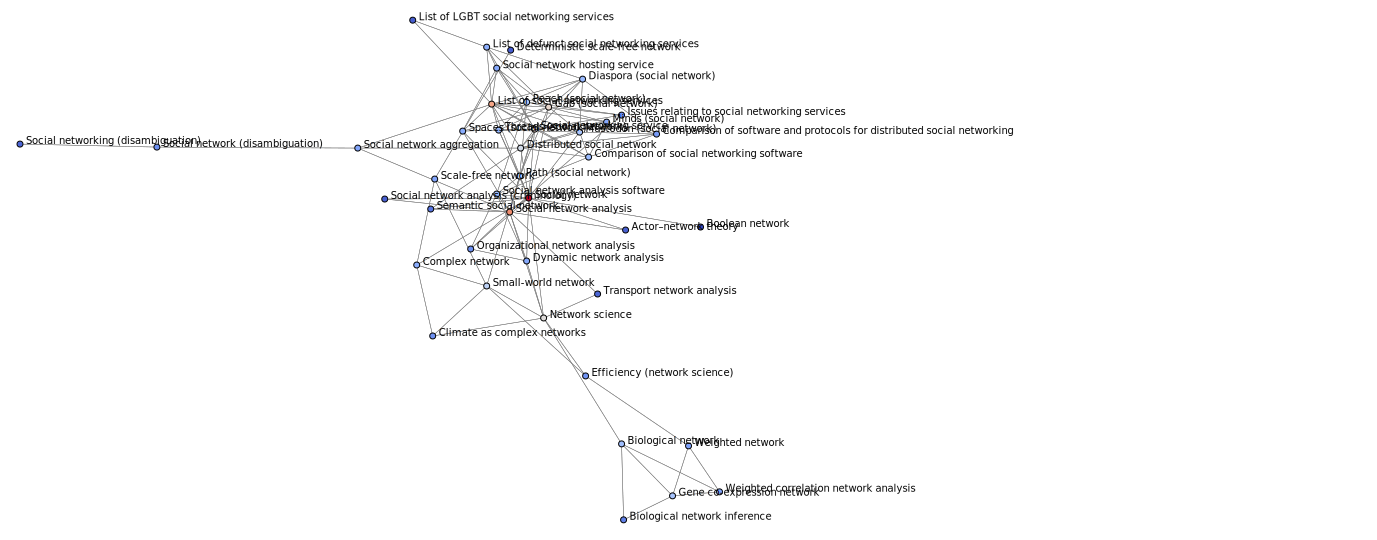

In [16]:
nodes = community_df[community_df['community']==comm_idx[1]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [17]:
[print(n) for n in sorted(G_comm.nodes)]

Actor–network theory
Biological network
Biological network inference
Boolean network
Climate as complex networks
Comparison of social networking software
Comparison of software and protocols for distributed social networking
Complex network
Deterministic scale-free network
Diaspora (social network)
Distributed social network
Dynamic network analysis
Efficiency (network science)
French orthography
Gab (social network)
Gene co-expression network
Global shipping network
International auxiliary language orthography
Issues relating to social networking services
Krackhardt kite graph
Level of detail (computer graphics)
List of LGBT social networking services
List of defunct social networking services
List of social networking services
Mastodon (social network)
Minds (social network)
NOFX discography
Network science
Organizational network analysis
Path (social network)
Peach (social network)
Robustness of complex networks
Scale-free network
Semantic social network
Single-frequency network
Sma

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

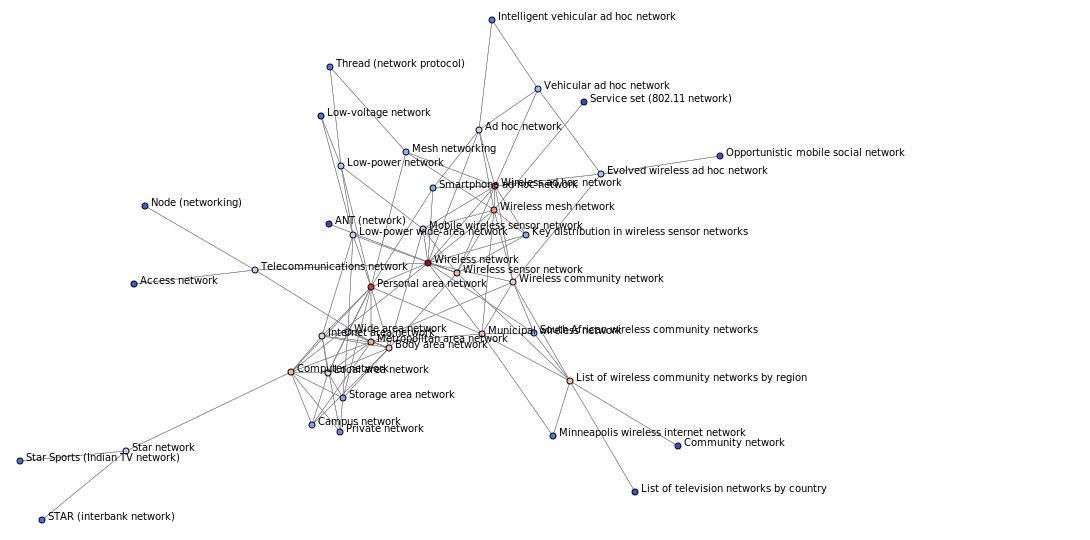

In [18]:
nodes = community_df[community_df['community']==comm_idx[2]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [19]:
[print(n) for n in sorted(G_comm.nodes)]

ANT (network)
Access network
Ad hoc network
Body area network
Bus network
Campus network
Clos network
Community network
Computer network
Evolved wireless ad hoc network
Hypertree network
Intelligent vehicular ad hoc network
Internet area network
Key distribution in wireless sensor networks
List of television networks by country
List of wireless community networks by region
Local area network
Low-power network
Low-power wide-area network
Low-voltage network
Mesh networking
Metropolitan area network
Minneapolis wireless internet network
Mobile wireless sensor network
Municipal wireless network
Near-me area network
Node (networking)
Opportunistic mobile social network
Personal area network
Private network
Ring network
STAR (interbank network)
Service set (802.11 network)
Smartphone ad hoc network
South African wireless community networks
Star Sports (Indian TV network)
Star network
Storage area network
Telecommunications network
Thread (network protocol)
Vehicular ad hoc network
Wide area

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

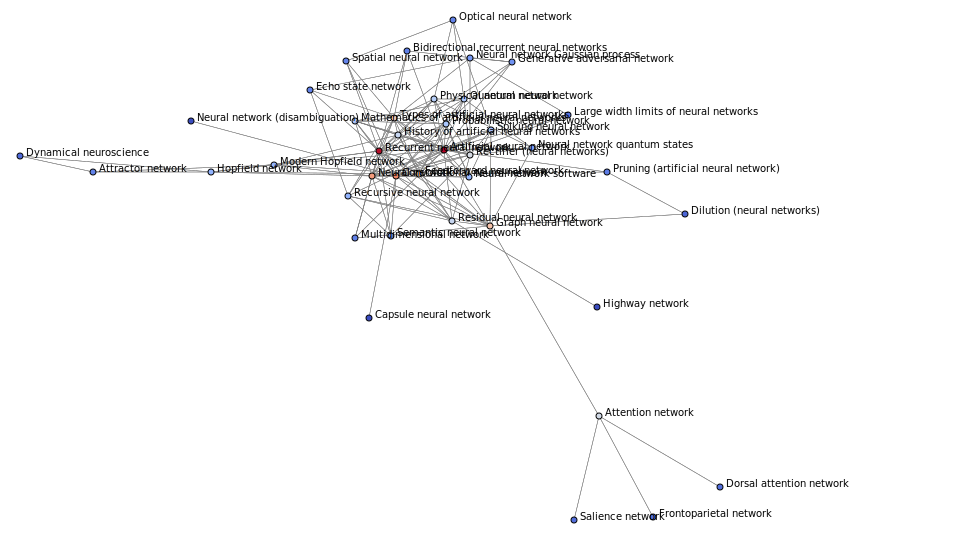

In [20]:
nodes = community_df[community_df['community']==comm_idx[3]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [21]:
[print(n) for n in sorted(G_comm.nodes)]

Artificial neural network
Attention network
Attractor network
Bidirectional recurrent neural networks
Capsule neural network
Convolutional deep belief network
Convolutional neural network
Deep belief network
Deepfake pornography
Dilution (neural networks)
Dorsal attention network
Dynamical neuroscience
Echo state network
Electroencephalography
Feedforward (behavioral and cognitive science)
Feedforward neural network
Frontoparietal network
Generative adversarial network
Graph neural network
Highway network
History of artificial neural networks
Holographic associative memory
Hopfield network
Large width limits of neural networks
Machine learning in earth sciences
Mathematics of artificial neural networks
Meta-learning (computer science)
Modern Hopfield network
Multidimensional network
Neural network
Neural network (disambiguation)
Neural network Gaussian process
Neural network quantum states
Neural network software
Optical neural network
Physical neural network
Probabilistic neural netwo

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

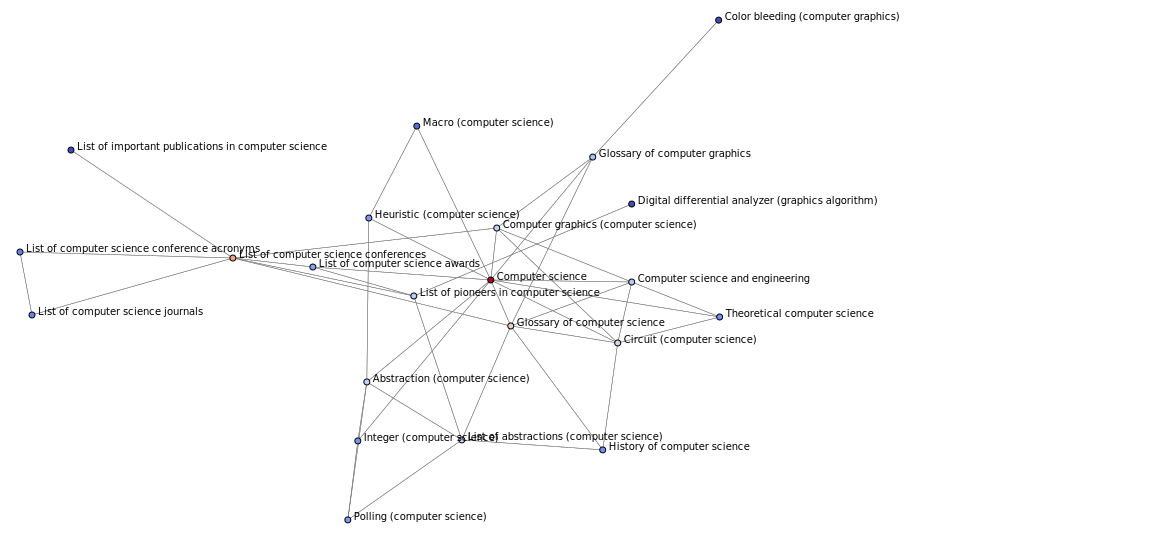

In [22]:
nodes = community_df[community_df['community']==comm_idx[4]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [23]:
[print(n) for n in sorted(G_comm.nodes)]

Abstraction (computer science)
Circuit (computer science)
Color bleeding (computer graphics)
Computer graphics (computer science)
Computer science
Computer science and engineering
Digital differential analyzer (graphics algorithm)
Glossary of computer graphics
Glossary of computer science
Heuristic (computer science)
History of computer science
Integer (computer science)
Learning sciences
List of abstractions (computer science)
List of computer science awards
List of computer science conference acronyms
List of computer science conferences
List of computer science journals
List of important publications in computer science
List of pioneers in computer science
Macro (computer science)
Node (computer science)
Polling (computer science)
Software engineering demographics
Theoretical computer science


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

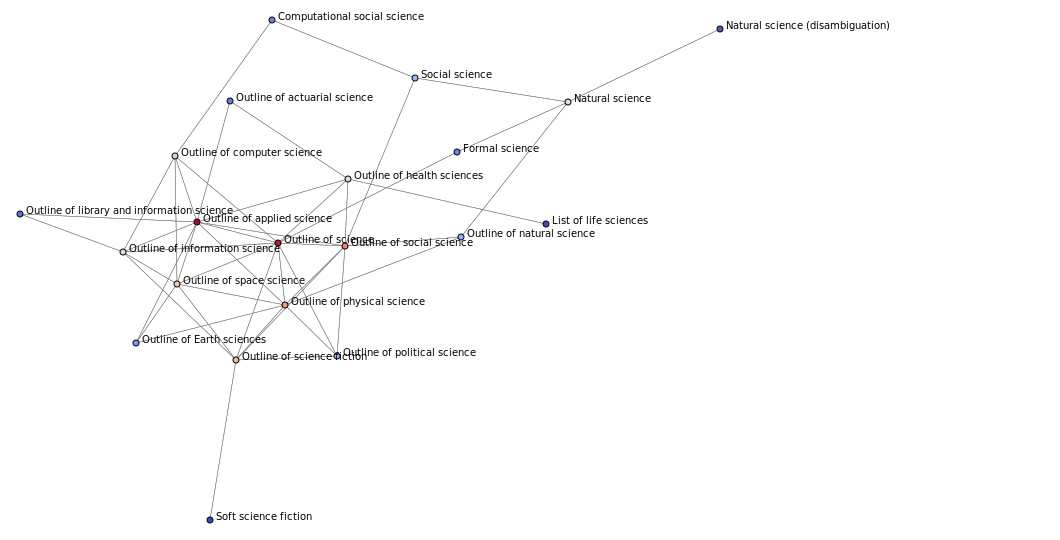

In [24]:
nodes = community_df[community_df['community']==comm_idx[5]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [25]:
[print(n) for n in sorted(G_comm.nodes)]

Computational social science
Formal science
List of life sciences
Natural science
Natural science (disambiguation)
Outline of Earth sciences
Outline of actuarial science
Outline of applied science
Outline of computer science
Outline of health sciences
Outline of information science
Outline of library and information science
Outline of military science and technology
Outline of natural science
Outline of physical science
Outline of political science
Outline of science
Outline of science fiction
Outline of social science
Outline of space science
Social science
Sociology of the history of science
Soft science fiction


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

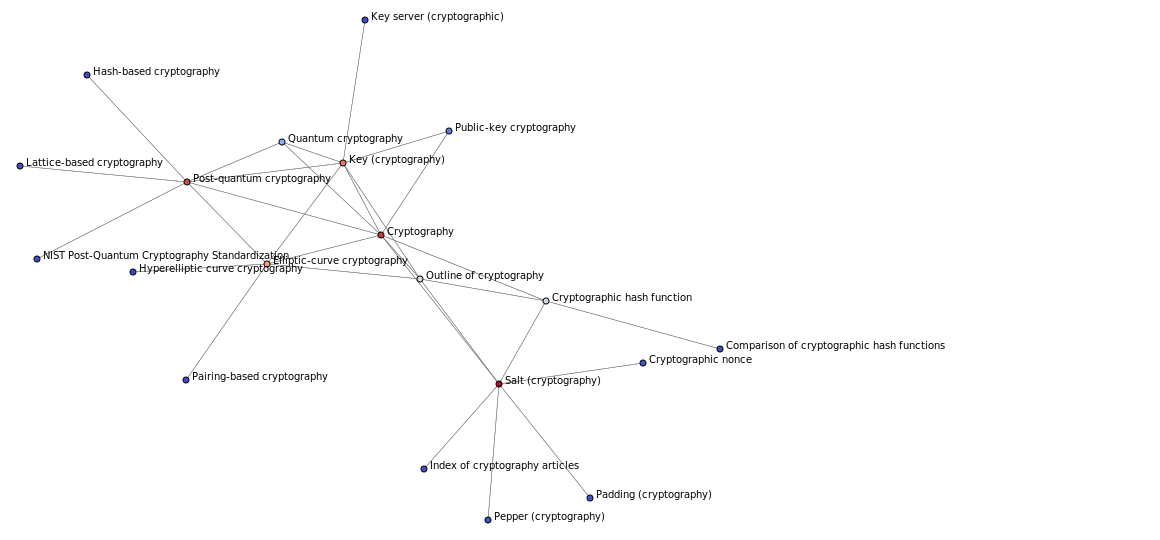

In [26]:
nodes = community_df[community_df['community']==comm_idx[6]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [27]:
[print(n) for n in sorted(G_comm.nodes)]

Comparison of cryptographic hash functions
Cryptographic hash function
Cryptographic key types
Cryptographic nonce
Cryptography
Elliptic-curve cryptography
Hash-based cryptography
Hyperelliptic curve cryptography
Index of cryptography articles
Key (cryptography)
Key server (cryptographic)
Lattice-based cryptography
List of cryptographers
NIST Post-Quantum Cryptography Standardization
Outline of cryptography
Padding (cryptography)
Pairing-based cryptography
Pepper (cryptography)
Post-quantum cryptography
Public-key cryptography
Quantum cryptography
Salt (cryptography)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

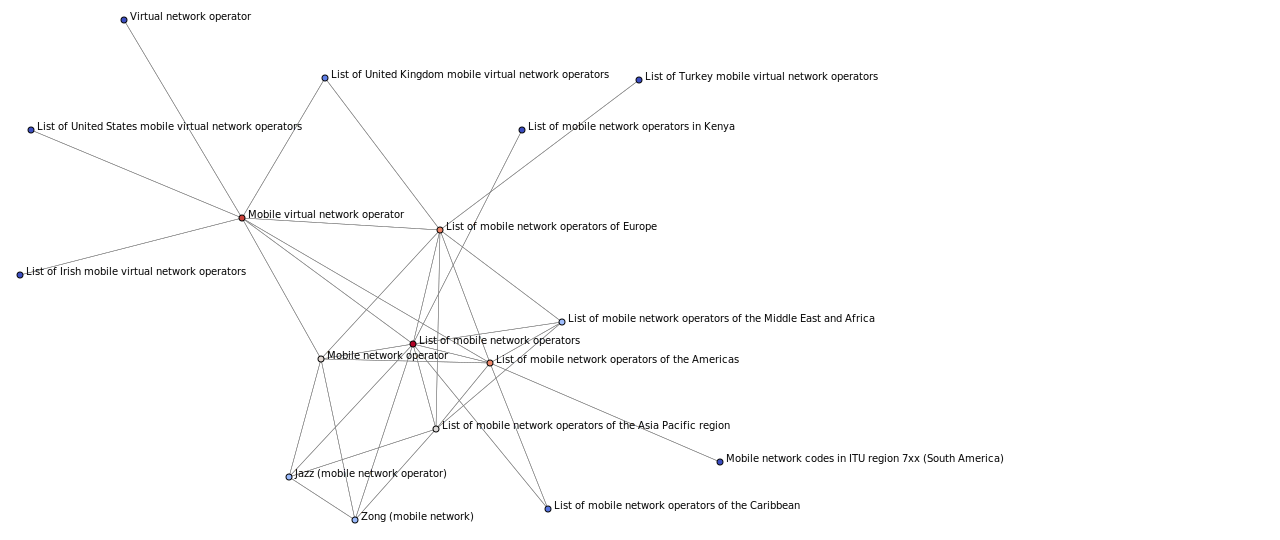

In [28]:
nodes = community_df[community_df['community']==comm_idx[7]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [29]:
[print(n) for n in sorted(G_comm.nodes)]

Jazz (mobile network operator)
List of Irish mobile virtual network operators
List of Turkey mobile virtual network operators
List of United Kingdom mobile virtual network operators
List of United States mobile virtual network operators
List of mobile network operators
List of mobile network operators in Kenya
List of mobile network operators of Europe
List of mobile network operators of the Americas
List of mobile network operators of the Asia Pacific region
List of mobile network operators of the Caribbean
List of mobile network operators of the Middle East and Africa
Mobile network codes in ITU region 7xx (South America)
Mobile network operator
Mobile virtual network operator
Virtual network operator
Zong (mobile network)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

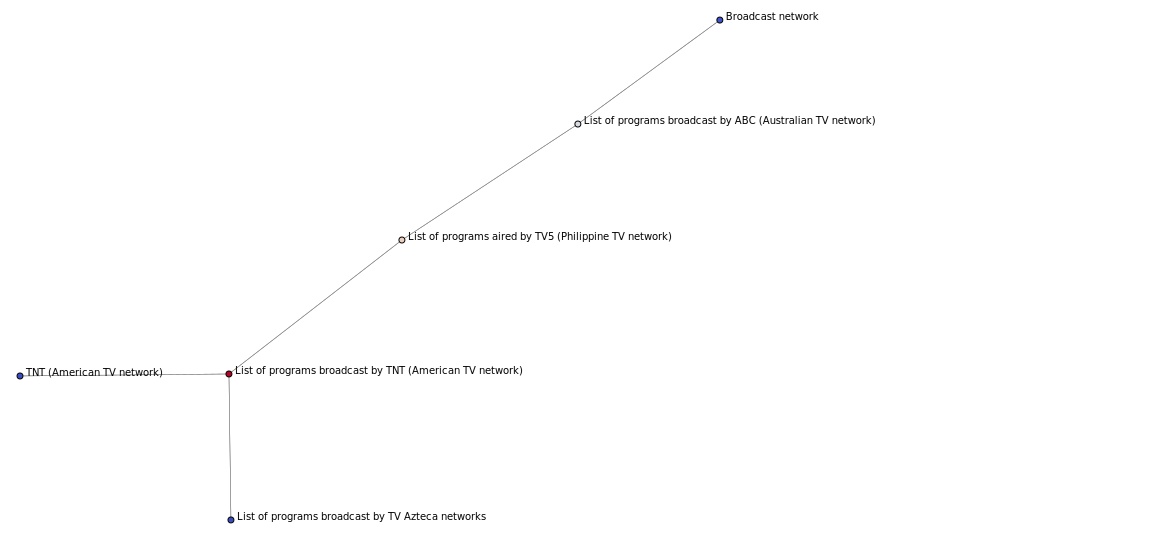

In [30]:
nodes = community_df[community_df['community']==comm_idx[8]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [31]:
[print(n) for n in sorted(G_comm.nodes)]

Boomerang (TV network)
Broadcast network
GTV (Philippine TV network)
Jamie Foxx filmography
List of programs aired by TV5 (Philippine TV network)
List of programs broadcast by ABC (American TV network)
List of programs broadcast by ABC (Australian TV network)
List of programs broadcast by GTV (Philippine TV network)
List of programs broadcast by History (American TV network)
List of programs broadcast by TNT (American TV network)
List of programs broadcast by TV Azteca networks
List of programs broadcast by TV5 (Philippine TV network)
List of science fiction television programs
TLC (TV network)
TNT (American TV network)
TV5 (Philippine TV network)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

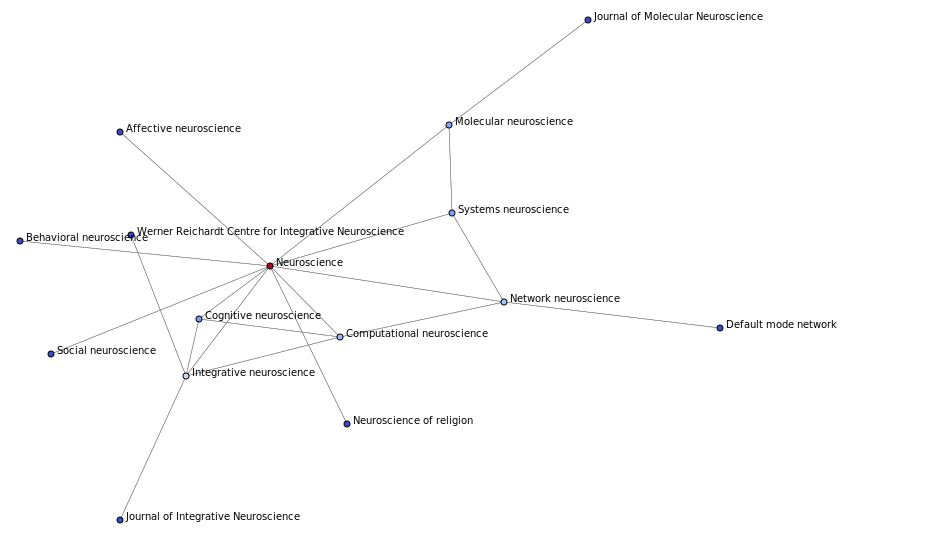

In [32]:
nodes = community_df[community_df['community']==comm_idx[9]]['node'].values

G_comm = G.subgraph(nodes)

draw_graph(nx.k_core(G_comm, 1), show_names=True, node_size=3)

In [33]:
[print(n) for n in sorted(G_comm.nodes)]

Affective neuroscience
Behavioral neuroscience
Cognitive neuroscience
Computational neuroscience
Default mode network
Integrative neuroscience
Journal of Integrative Neuroscience
Journal of Molecular Neuroscience
Molecular neuroscience
Network neuroscience
Neuroscience
Neuroscience of religion
Social neuroscience
Systems neuroscience
Werner Reichardt Centre for Integrative Neuroscience


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Keyword Lookups
The graph approach is more informative, as pages that link to each other will appear in the same community graphs. However, we could do some simple text lookups to guide us as well. I'm going to use G.nodes to get the list of nodes, but I could also use the Pandas edgelist DataFrame. It'd just take more steps. 

I will do the following:
- Get a list of all nodes in the network
- Find nodes that contain the word 'network' or 'graph'

In [34]:
nodes = sorted(G.nodes)
nodes[0:10]

['!!',
 '$5',
 "'97 Bonnie & Clyde",
 "'Cause",
 "'GAPÔ",
 "'Salem's Lot",
 "'t Hooft–Polyakov monopole",
 '(Almost) Straight Outta Compton',
 '(I Love You) For Sentimental Reasons',
 '(Until) Your Love Broke Through']

I can see that even in this Wikipedia network, there are some junk nodes. But with Graphs--as shown above in Community Detection--it is easy to brush right past the noise and find the action.

In [35]:
[n for n in nodes if n.endswith('graph') or n.endswith('network')]

['1-planar graph',
 'Abstract semantic graph',
 'Access network',
 'Acyclic graph',
 'Ad hoc network',
 'Advertising network',
 'Affiliate network',
 'Ancestral graph',
 'Antimetric electrical network',
 'Apex graph',
 'Artificial neural network',
 'Attention network',
 'Attractor network',
 'Augmented transition network',
 'Backbone network',
 'Balanced hypergraph',
 'Bayesian network',
 'Benefit dependency network',
 'Berlekamp–Van Lint–Seidel graph',
 'Biconnected graph',
 'Bidirected graph',
 'Biological network',
 'Bipartite graph',
 'Bipartite hypergraph',
 'Bitcoin network',
 'Block graph',
 'Body area network',
 'Bond graph',
 'Boolean network',
 'Broadcast network',
 'Bull graph',
 'Bus network',
 'Butterfly graph',
 'Cactus graph',
 'Call graph',
 'Campus network',
 'Capsule neural network',
 'Causal graph',
 'Cayley graph',
 'Cellular network',
 'Cellular neural network',
 'Chordal bipartite graph',
 'Chordal graph',
 'Chvátal graph',
 'Circle graph',
 'Circulant graph',
 'C

This gives us clean results that we could use, but it does not show how terms relate to each other. I'll stop here. It's possible to lookup with text, but I like the Community Detection approach a lot better.

At the beginning of Community Detection, I kept a list of the nodes from the largest Network Science community.

In nx.k_core, notice the number 6. I am looking for nodes with six or more edges. I am looking for the core of this network. Sometimes, the maximum depth you can go is a lower number, if you do it this way. Every network is different. 

I recommend starting at 3, and then increasing by 1 until you hit Python errors

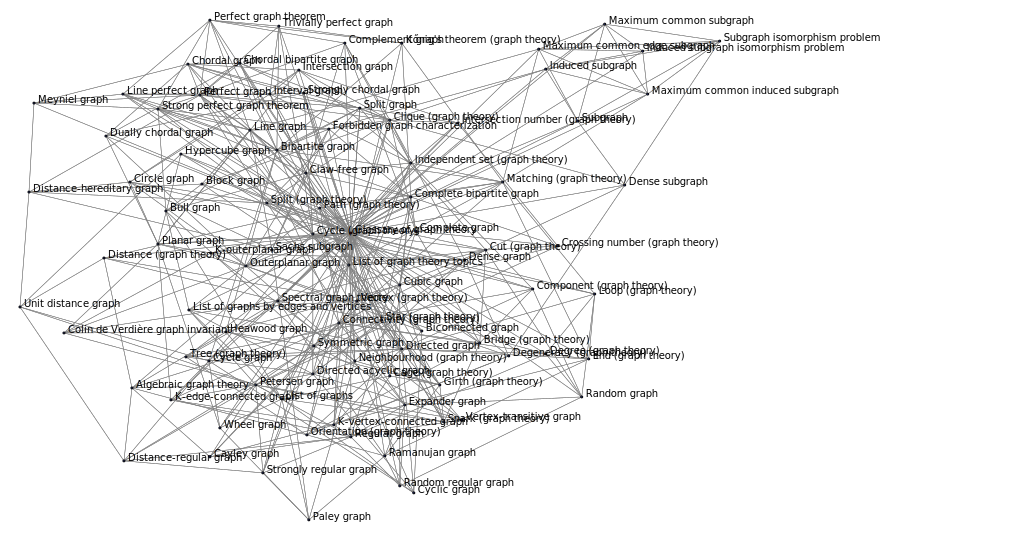

In [36]:
draw_graph(nx.k_core(G_net_main,6), show_names=True)

In [40]:
draw_graph(nx.k_core(G_net_main,7), show_names=True) 

# this is what an error will look like, for demonstration
# there are no nodes with seven or more edges that have a link between them. Thus, there is no graph at that depth.

NetworkXError: Graph has no nodes or edges

We can use k_corona to create a graph containing nodes with EXACTLY six edges, and how they link together. We could use this approach to build our study list. Rather than attempt to learn everything at once, we could start peeling this onion, layer by layer, and study topics in the order of most connected to least connected. 

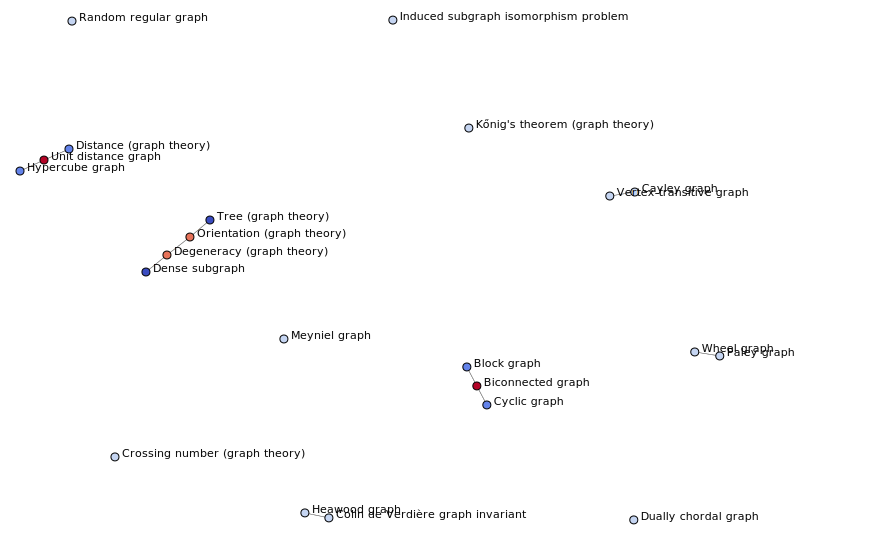

In [41]:
G_check = nx.k_corona(G_net_main, 6)

draw_graph(G_check, show_names=True, node_size=4, font_size=11)

I don't want to copy and paste by hand, though. I want to get a list of nodes at this layer. Let's do that, and just know that we can visualize if we really wanted to.

In [42]:
sorted(G_check.nodes)

['Biconnected graph',
 'Block graph',
 'Cayley graph',
 'Colin de Verdière graph invariant',
 'Crossing number (graph theory)',
 'Cyclic graph',
 'Degeneracy (graph theory)',
 'Dense subgraph',
 'Distance (graph theory)',
 'Dually chordal graph',
 'Heawood graph',
 'Hypercube graph',
 'Induced subgraph isomorphism problem',
 "Kőnig's theorem (graph theory)",
 'Meyniel graph',
 'Orientation (graph theory)',
 'Paley graph',
 'Random regular graph',
 'Tree (graph theory)',
 'Unit distance graph',
 'Vertex-transitive graph',
 'Wheel graph']

Nice. That is a much shorder list. So, we know that 6 is max depth. Let's start at 6 and work our way to 0, building a study guide in the process.

In [43]:
step = 1

for i in range(6, -1, -1):
    
    print('Learning Step {}: \n'.format(step))
    nodes = sorted(nx.k_corona(G_net_main, i).nodes)
    
    for node in nodes:
        print(' - {}'.format(node))
    print()
    
    step += 1


Learning Step 1: 

 - Biconnected graph
 - Block graph
 - Cayley graph
 - Colin de Verdière graph invariant
 - Crossing number (graph theory)
 - Cyclic graph
 - Degeneracy (graph theory)
 - Dense subgraph
 - Distance (graph theory)
 - Dually chordal graph
 - Heawood graph
 - Hypercube graph
 - Induced subgraph isomorphism problem
 - Kőnig's theorem (graph theory)
 - Meyniel graph
 - Orientation (graph theory)
 - Paley graph
 - Random regular graph
 - Tree (graph theory)
 - Unit distance graph
 - Vertex-transitive graph
 - Wheel graph

Learning Step 2: 

 - Acyclic graph
 - Cheeger constant (graph theory)
 - Clique graph
 - Code property graph
 - Covering graph
 - Cycle graph (algebra)
 - Edge-transitive graph
 - Extremal graph theory
 - Hall-type theorems for hypergraphs
 - Median graph
 - Polyhedral graph
 - Rooted graph
 - Topological graph
 - Windmill graph

Learning Step 3: 

 - Call graph
 - Closed graph property
 - Directed acyclic word graph
 - Factor-critical graph
 - Flow grap

Nice. This is clean, and I can use this to learn about each of these. Each one of these is a page on Wikipedia, and that can be a starting point. Let's see what Wikipedia has to say about Biconnected graphs.

# Wikipedia Checks
We can use the Wikipedia Python library to look at any of these pages (or we can use a browser).

In [56]:
#!pip install wikipedia

In [57]:
import wikipedia as w
from time import sleep

In [58]:
search = 'Biconnected graph'

page = w.page(search)

In [59]:
page.categories

['Articles with short description',
 'Graph connectivity',
 'Graph families',
 'Short description matches Wikidata']

In [60]:
print(page.content)

In graph theory, a biconnected graph is a connected and "nonseparable" graph, meaning that if any one vertex were to be removed, the graph will remain connected. Therefore a biconnected graph has no articulation vertices.
The property of being 2-connected is equivalent to biconnectivity, except that the complete graph of two vertices is usually not regarded as 2-connected.
This property is especially useful in maintaining a graph with a two-fold redundancy, to prevent disconnection upon the removal of a single edge (or connection).
The use of biconnected graphs is very important in the field of networking (see Network flow), because of this property of redundancy.


== Definition ==
A biconnected undirected graph is a connected graph that is not broken into disconnected pieces by deleting any single vertex (and its incident edges).
A biconnected directed graph is one such that for any two vertices v and w there are two directed paths from v to w which have no vertices in common other t

In [61]:
page.images

['https://upload.wikimedia.org/wikipedia/commons/e/ea/4_Node_Biconnected.svg',
 'https://upload.wikimedia.org/wikipedia/commons/1/11/4_Node_Not-Biconnected.svg',
 'https://upload.wikimedia.org/wikipedia/commons/7/77/5_Node_Biconnected.svg',
 'https://upload.wikimedia.org/wikipedia/commons/8/82/5_Node_Not-Biconnected.svg']

In [62]:
page.links

['Algebraic connectivity',
 'Articulation vertex',
 'Biconnected component',
 'Bridge (graph theory)',
 'Complete graph',
 'Connectivity (graph theory)',
 'Cycle rank',
 'Directed graph',
 'Edge (graph theory)',
 'Flow network',
 'Graph (discrete mathematics)',
 'Graph connectivity',
 'Graph theory',
 'K-connectivity certificate',
 'K-vertex-connected graph',
 'On-Line Encyclopedia of Integer Sequences',
 'Pixel connectivity',
 'Rank (graph theory)',
 'Redundancy (engineering)',
 'SPQR tree',
 'St-connectivity',
 'Strongly connected component',
 'Undirected graph',
 'Vertex (graph theory)',
 'Vertex separator']

In [63]:
page.references

['http://mathworld.wolfram.com/BiconnectedGraph.html',
 'https://code.google.com/p/jbpt/',
 'https://xlinux.nist.gov/dads/HTML/biconnectedGraph.html']

In [64]:
page.summary

'In graph theory, a biconnected graph is a connected and "nonseparable" graph, meaning that if any one vertex were to be removed, the graph will remain connected. Therefore a biconnected graph has no articulation vertices.\nThe property of being 2-connected is equivalent to biconnectivity, except that the complete graph of two vertices is usually not regarded as 2-connected.\nThis property is especially useful in maintaining a graph with a two-fold redundancy, to prevent disconnection upon the removal of a single edge (or connection).\nThe use of biconnected graphs is very important in the field of networking (see Network flow), because of this property of redundancy.\n\n'

In [65]:
page.url

'https://en.wikipedia.org/wiki/Biconnected_graph'

# Thanks for Following!
Thanks for following along! This was a quick approach to create a learning approach from any Wikipedia graph that was created using the Wikipedia crawler I posted on day 5. I hope you find this useful, and I truly hope people will use this to study what they want to study, not necessarily a Network Science graph, like I did. For instance, today, I was considering building a network related to the old TV show 'ALF', just for fun. I'll do that another day.